Cell 1 — Upload / prepare data (run first)

In [1]:
# Cell 0: Upload / prepare data (run once at start)
from google.colab import files
import os
import shutil

BASE_DIR = "/content/project_data"
os.makedirs(BASE_DIR, exist_ok=True)

print("If you already uploaded files to /content/project_data, skip upload.")
print("Recommended files to upload (optional):")
print(" - training.1600000.processed.noemoticon.csv")
print(" - depressive_tweets_processed.csv")
print(" - contractions.json")
print(" - GoogleNews-vectors-negative300.bin.gz  (optional, large)")

uploaded = files.upload()  # choose files from your machine

# Move uploaded files to project_data
for fname in uploaded.keys():
    dst = os.path.join(BASE_DIR, fname)
    # if file already exists, replace
    if os.path.exists(dst):
        os.remove(dst)
    shutil.move(fname, dst)

print("Files in", BASE_DIR, ":", os.listdir(BASE_DIR))


If you already uploaded files to /content/project_data, skip upload.
Recommended files to upload (optional):
 - training.1600000.processed.noemoticon.csv
 - depressive_tweets_processed.csv
 - contractions.json
 - GoogleNews-vectors-negative300.bin.gz  (optional, large)


Saving contractions.json to contractions.json
Saving depressive_tweets_processed.csv to depressive_tweets_processed.csv
Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv
Files in /content/project_data : ['training.1600000.processed.noemoticon.csv', 'contractions.json', 'depressive_tweets_processed.csv']


Cell 2 — Imports & setup

In [11]:
# Cell 1: Imports & setup
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import os
import re
import random
import logging
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

%matplotlib inline

# Try imports (do not pip-install large packages automatically, to avoid NumPy binary mismatches)
try:
    import nltk
    from nltk.corpus import stopwords
except Exception:
    !pip install -q nltk
    import nltk
    from nltk.corpus import stopwords

try:
    import preprocessor as p
except Exception:
    !pip install -q tweet-preprocessor
    import preprocessor as p

try:
    from wordcloud import WordCloud
except Exception:
    !pip install -q wordcloud
    from wordcloud import WordCloud

# gensim is optional (heavy). We'll try import and if unavailable we fallback to random embeddings.
GENSIM_AVAILABLE = True
try:
    from gensim.models import KeyedVectors
except Exception:
    GENSIM_AVAILABLE = False

# TensorFlow / Keras imports (use tf.keras)
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
    from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
    from tensorflow.keras.models import Model
except Exception:
    # In Colab this should be present; if not, pip install (note: installing TF can be slow)
    !pip install -q tensorflow
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
    from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
    from tensorflow.keras.models import Model

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Additional classical models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

# NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Print summary of optional availability
logger.info("Gensim available: %s", GENSIM_AVAILABLE)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cell 3 — Configuration

In [9]:
# =========================
# Cell 2: Configuration
# =========================
DATA_DIR = "/content/project_data"   # where you uploaded the files

# Use plain filenames since files are directly in project_data
SENTIMENT140_CSV = 'training.1600000.processed.noemoticon.csv'
DEPRESSIVE_TWEETS = 'depressive_tweets_processed.csv'
CONTRACTIONS_JSON = 'contractions.json'
WORD2VEC_BIN = 'GoogleNews-vectors-negative300.bin.gz'


MAX_NUM_WORDS = 10000
MAX_SEQ_LENGTH = 140
EMBEDDING_DIM = 300

# Try to resolve absolute paths for convenience
SENTIMENT140_PATH = os.path.join(DATA_DIR, SENTIMENT140_CSV)
DEPRESSIVE_PATH = os.path.join(DATA_DIR, DEPRESSIVE_TWEETS)
CONTRACTIONS_PATH = os.path.join(DATA_DIR, CONTRACTIONS_JSON)
WORD2VEC_PATH = os.path.join(DATA_DIR, WORD2VEC_BIN)

# Print what exists
logger.info("Data dir: %s", DATA_DIR)
logger.info("Sentiment140 exists: %s", os.path.exists(SENTIMENT140_PATH))
logger.info("Depressive tweets exists: %s", os.path.exists(DEPRESSIVE_PATH))
logger.info("Contractions exists: %s", os.path.exists(CONTRACTIONS_PATH))
logger.info("Word2Vec exists: %s", os.path.exists(WORD2VEC_PATH))


Cell 4 — Utilities: DataLoader, Preprocessor, EmbeddingManager

In [4]:
# Cell 3: Utilities (DataLoader, Preprocessor, EmbeddingManager)
class DataLoader:
    def __init__(self, data_dir: str):
        self.data_dir = data_dir

    def _path(self, relative: str) -> str:
        return os.path.join(self.data_dir, relative)

    def load_sentiment140(self, sample_n: int = 8000, encoding='ISO-8859-1') -> pd.DataFrame:
        path = self._path(SENTIMENT140_CSV)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Sentiment140 file not found at {path}")
        logger.info("Loading Sentiment140 (sample=%d) from %s", sample_n, path)
        col_names = ['target','id','date','flag','user','text']
        df = pd.read_csv(path, encoding=encoding, names=col_names)
        df_sample = df.copy().sample(sample_n, random_state=SEED)
        df_sample = df_sample[['text']].copy()
        df_sample['label'] = 0
        return df_sample

    def load_depressive_tweets(self, nrows: int = 3200) -> pd.DataFrame:
        path = self._path(DEPRESSIVE_TWEETS)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Depressive tweets file not found at {path}")
        logger.info("Loading depressive tweets (nrows=%d) from %s", nrows, path)
        col_names = ['id','text']
        df2 = pd.read_csv(path, sep='|', header=None, usecols=[0,5], nrows=nrows, names=col_names)
        df2 = df2[['text']].copy()
        df2['label'] = 1
        return df2

    def load_contractions(self) -> Dict[str,str]:
        path = self._path(CONTRACTIONS_JSON)
        if not os.path.exists(path):
            logger.warning("Contractions JSON not found at %s. Using empty contractions.", path)
            return {}
        s = pd.read_json(path, typ='series')
        # normalize keys to lowercase and escape for regex
        return {str(k).lower(): v for k, v in s.to_dict().items()}


class Preprocessor:
    def __init__(self, contractions: Dict[str,str] = None):
        self.contractions = contractions or {}
        if self.contractions:
            # escape keys and sort longer first to avoid partial matches
            keys = sorted(self.contractions.keys(), key=lambda x: -len(x))
            keys_escaped = list(map(re.escape, keys))
            pattern = '|'.join(keys_escaped)
            self.c_re = re.compile('(%s)' % pattern)
        else:
            self.c_re = None
        self.BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    def expand_contractions(self, text: str) -> str:
        if not self.c_re:
            return text
        def replace(match):
            grp = match.group(0).lower()
            return self.contractions.get(grp, grp)
        return self.c_re.sub(replace, text)

    def clean_tweet(self, tweet: str) -> str:
        tweet = str(tweet).lower()
        tweet = self.BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)  # remove urls, mentions, hashtags normalization
        tweet = self.expand_contractions(tweet)
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
        stop_words = set(nltk.corpus.stopwords.words('english'))
        tokens = nltk.word_tokenize(tweet)
        filtered = [w for w in tokens if w not in stop_words]
        return ' '.join(filtered)

    def clean_tweets(self, tweets: List[str]) -> List[str]:
        return [self.clean_tweet(t) for t in tweets]


class EmbeddingManager:
    def __init__(self, data_dir: str, word_index: Dict[str,int], max_num_words: int = MAX_NUM_WORDS, emb_dim: int = EMBEDDING_DIM):
        self.data_dir = data_dir
        self.word_index = word_index
        self.max_num_words = max_num_words
        self.emb_dim = emb_dim
        self.embedding_matrix = np.zeros((self.max_num_words, self.emb_dim), dtype=np.float32)

    def load_word2vec(self, relative_path: str = WORD2VEC_BIN) -> bool:
        if not GENSIM_AVAILABLE:
            logger.warning("Gensim not available in this runtime. Skipping Word2Vec load.")
            return False
        path = os.path.join(self.data_dir, relative_path)
        if not os.path.exists(path):
            logger.warning("Word2Vec file not found at %s. Falling back to random embeddings.", path)
            return False
        try:
            logger.info("Loading Word2Vec binary from %s (this can take some minutes)...", path)
            wv = KeyedVectors.load_word2vec_format(path, binary=True)
            known = 0
            for word, idx in self.word_index.items():
                if idx >= self.max_num_words:
                    continue
                if word in wv.key_to_index:
                    self.embedding_matrix[idx] = wv.get_vector(word)
                    known += 1
            logger.info("Loaded embeddings for %d tokens", known)
            return True
        except Exception as e:
            logger.warning("Failed to load Word2Vec due to: %s. Falling back to random embeddings.", e)
            return False

    def build_random_embeddings(self):
        logger.info("Building small random embeddings.")
        rng = np.random.RandomState(SEED)
        self.embedding_matrix = (rng.normal(size=(self.max_num_words, self.emb_dim)).astype(np.float32) * 0.01)


Cell 5 — Models: SVC wrapper and LSTM classifier

In [5]:
# Cell 4: model wrappers
class BaselineSVCModel:
    def __init__(self):
        self.model = SVC()

    def fit(self, X, y):
        logger.info("Training baseline SVC (TF-IDF features).")
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


class LSTMClassifier:
    def __init__(self, max_seq_len=MAX_SEQ_LENGTH, max_num_words=MAX_NUM_WORDS, emb_dim=EMBEDDING_DIM):
        self.max_seq_len = max_seq_len
        self.max_num_words = max_num_words
        self.emb_dim = emb_dim
        self.model = None

    def build(self, embedding_matrix: np.ndarray):
        logger.info("Building BiLSTM model.")
        inp = Input(shape=(self.max_seq_len,), name='input')
        x = Embedding(self.max_num_words, self.emb_dim, weights=[embedding_matrix], trainable=True, name='embedding')(inp)
        x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
        x = GlobalMaxPool1D()(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.25)(x)
        out = Dense(1, activation="sigmoid")(x)
        self.model = Model(inputs=inp, outputs=out)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()

    def fit(self, x_train, y_train, batch_size=16, epochs=10, validation_split=0.1):
        if self.model is None:
            raise RuntimeError("Model not built. Call build(embedding_matrix) first.")
        logger.info("Fitting BiLSTM model (epochs=%d, batch_size=%d)", epochs, batch_size)
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=2)

    def predict(self, x):
        preds = self.model.predict(x)
        return np.round(preds.flatten()).astype(int)


Cell 6 — PipelineRunner (run components easily)

In [6]:
# Cell 5: PipelineRunner
class PipelineRunner:
    def __init__(self, data_dir: str):
        self.data_loader = DataLoader(data_dir)
        self.preprocessor = None
        self.embedding_manager = None
        self.tokenizer = None
        self.df = None

    def prepare_data(self, sample_sentiment_n: int = 8000, depressive_n: int = 3200):
        df_pos = self.data_loader.load_sentiment140(sample_n=sample_sentiment_n)
        df_neg = self.data_loader.load_depressive_tweets(nrows=depressive_n)
        df = pd.concat([df_pos, df_neg], ignore_index=True)
        df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
        self.df = df
        logger.info("Combined dataset shape: %s", df.shape)
        contractions = self.data_loader.load_contractions()
        self.preprocessor = Preprocessor(contractions=contractions)

    def clean_and_tokenize(self):
        if self.df is None:
            raise RuntimeError("Data not prepared. Call prepare_data() first.")
        logger.info("Cleaning text (this may take a little while)...")
        X_clean = self.preprocessor.clean_tweets(self.df['text'].fillna('').tolist())
        self.df['clean_text'] = X_clean
        self.tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        self.tokenizer.fit_on_texts(X_clean)
        sequences = self.tokenizer.texts_to_sequences(X_clean)
        input_tensor = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
        logger.info("Tokenization done. Vocab size: %d", len(self.tokenizer.word_index))
        return input_tensor

    def compute_tfidf(self):
        logger.info("Computing TF-IDF matrix (for baseline SVC).")
        corpus = self.df['text'].astype('U').values
        tfidf = TfidfVectorizer(max_features=MAX_NUM_WORDS)
        X_tfidf = tfidf.fit_transform(corpus)
        return X_tfidf

    def create_embedding_matrix(self):
        logger.info("Preparing embedding matrix (Word2Vec fallback to random if not present).")
        word_index = self.tokenizer.word_index
        self.embedding_manager = EmbeddingManager(DATA_DIR, word_index, max_num_words=MAX_NUM_WORDS, emb_dim=EMBEDDING_DIM)
        loaded = self.embedding_manager.load_word2vec()
        if not loaded:
            self.embedding_manager.build_random_embeddings()
        return self.embedding_manager.embedding_matrix

    def run_baseline_svc(self, X_tfidf):
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, self.df['label'].values, test_size=0.3, random_state=SEED)
        svc = BaselineSVCModel()
        svc.fit(X_train, y_train)
        preds = svc.predict(X_test)
        logger.info("Baseline SVC accuracy: %f", accuracy_score(y_test, preds))
        print(classification_report(y_test, preds, digits=5))
        return (X_train, X_test, y_train, y_test)

    def run_lstm(self, input_tensor, epochs=10):
        X_train, X_test, y_train, y_test = train_test_split(input_tensor, self.df['label'].values, test_size=0.3, random_state=SEED)
        emb_mat = self.create_embedding_matrix()
        lstm = LSTMClassifier(max_seq_len=MAX_SEQ_LENGTH, max_num_words=MAX_NUM_WORDS, emb_dim=EMBEDDING_DIM)
        lstm.build(emb_mat)
        lstm.fit(X_train, y_train, batch_size=16, epochs=epochs, validation_split=0.1)
        preds = lstm.predict(X_test)
        logger.info("LSTM classification report:")
        print(classification_report(y_test, preds, digits=5))
        return (X_train, X_test, y_train, y_test, lstm)

    def run_classic_pipelines(self):
        x_train, x_test, y_train, y_test = train_test_split(self.df['clean_text'].values, self.df['label'].values, test_size=0.3, random_state=SEED)
        pipelines = {
            'nb': Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())]),
            'sgd': Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=SEED, max_iter=1000))]),
            'logreg': Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression(max_iter=1000))])
        }
        results = {}
        for name, pipe in pipelines.items():
            logger.info("Training pipeline: %s", name)
            pipe.fit(x_train, y_train)
            y_pred = pipe.predict(x_test)
            acc = accuracy_score(y_test, y_pred)
            logger.info("%s accuracy: %f", name, acc)
            print(f"==== {name.upper()} ====")
            print(classification_report(y_test, y_pred, digits=5))
            results[name] = (pipe, acc)
        return results


Cell 7 — Run the full pipeline (example)

              precision    recall  f1-score   support

           0    0.99586   1.00000   0.99793      2408
           1    1.00000   0.98563   0.99276       696

    accuracy                        0.99678      3104
   macro avg    0.99793   0.99282   0.99535      3104
weighted avg    0.99679   0.99678   0.99677      3104



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 140, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 200)       │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,341,001 (12.74 MB)

 Trainable params: 3,341,001 (12.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
408/408 - 279s - 684ms/step - accuracy: 0.9599 - loss: 0.1138 - val_accuracy: 0.9862 - val_loss: 0.0432
Epoch 2/5
408/408 - 282s - 692ms/step - accuracy: 0.9905 - loss: 0.0209 - val_accuracy: 0.9807 - val_loss: 0.0524
Epoch 3/5
408/408 - 283s - 694ms/step - accuracy: 0.9939 - loss: 0.0106 - val_accuracy: 0.9752 - val_loss: 0.0908
Epoch 4/5
408/408 - 319s - 782ms/step - accuracy: 0.9952 - loss: 0.0088 - val_accuracy: 0.9848 - val_loss: 0.0666
Epoch 5/5
408/408 - 312s - 766ms/step - accuracy: 0.9943 - loss: 0.0073 - val_accuracy: 0.9834 - val_loss: 0.0745
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step
              precision    recall  f1-score   support

           0    0.99208   0.98837   0.99022      2408
           1    0.96028   0.97270   0.96645       696

    accuracy                        0.98486      3104
   macro avg    0.97618   0.98054   0.97834      3104
weighted avg    0.98495   0.98486   0.98489      3104

==== NB ====
              precision    recall  f1-score   su

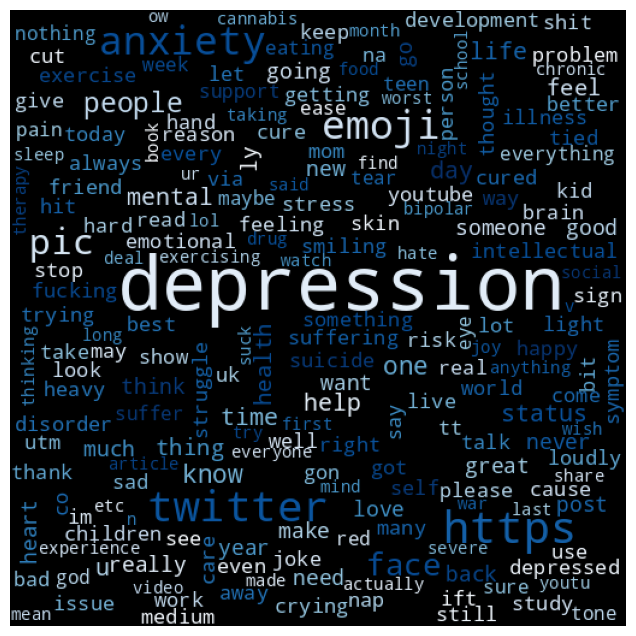

In [12]:
# Cell 6: Run the full pipeline (example)
runner = PipelineRunner(DATA_DIR)
runner.prepare_data(sample_sentiment_n=8000, depressive_n=3200)

# Clean and tokenize
input_tensor = runner.clean_and_tokenize()

# TF-IDF + baseline SVC
X_tfidf = runner.compute_tfidf()
_ = runner.run_baseline_svc(X_tfidf)

# Run LSTM (if you want faster demo, set epochs=3)
_ = runner.run_lstm(input_tensor, epochs=5)

# Classic pipelines (NB, SGD, Logistic)
_ = runner.run_classic_pipelines()

# Optional: Word cloud for depressive tweets (cleaned)
try:
    depressive_clean = runner.preprocessor.clean_tweets(runner.data_loader.load_depressive_tweets(nrows=3200)['text'].fillna('').tolist())
    words = ' '.join(depressive_clean)
    wc = WordCloud(width=512, height=512, collocations=False, colormap="Blues").generate(words)
    plt.figure(figsize=(10,8))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
except Exception as e:
    logger.warning("Could not create word cloud: %s", e)
